# 1. Tracking simple objects in videos

## 1.1 Particle Filters

In [1]:
from pathlib import Path
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.widgets import RectangleSelector

In [2]:
%matplotlib widget

In [3]:
# répertoire racine de ton TP (le notebook se trouve déjà ici)
ROOT = Path("video_sequences")

# vidéos (synthetic / real)
VID_DIR = ROOT  / "synthetic"

# choisis la vidéo à initialiser (tu peux changer ce nom et relancer)
VIDEO_NAME = "escrime-4-3.avi"
VIDEO_PATH = VID_DIR / VIDEO_NAME

assert VIDEO_PATH.exists(), f"Fichier vidéo introuvable: {VIDEO_PATH}"

# où sauvegarder l'init (centre + taille) pour réutiliser aux étapes 2/3
INIT_DIR = Path("initialization")
INIT_DIR.mkdir(exist_ok=True)
INIT_JSON = INIT_DIR / f"{Path(VIDEO_NAME).stem}_init.json"

print("Vidéo:", VIDEO_PATH)
print("Fichier d'init:", INIT_JSON)

Vidéo: video_sequences/synthetic/escrime-4-3.avi
Fichier d'init: initialization/escrime-4-3_init.json


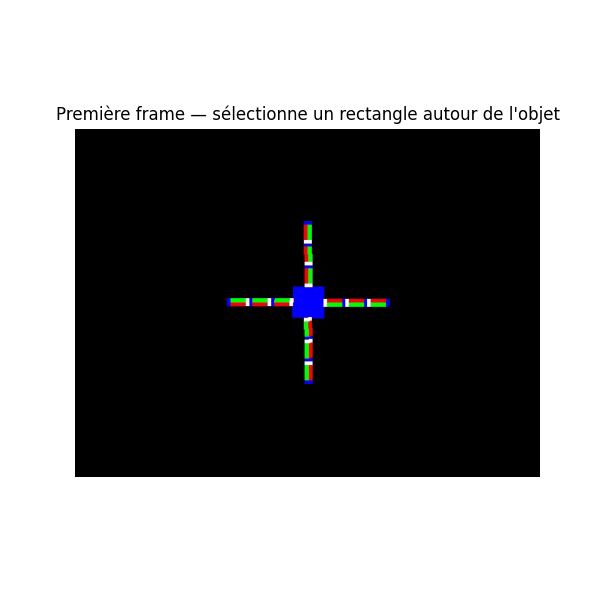

In [7]:
# === STEP 1: lire la première frame ===
cap = cv2.VideoCapture(str(VIDEO_PATH))
ok, frame0 = cap.read()
cap.release()
assert ok, "Impossible de lire la première frame"

# OpenCV lit en BGR -> convertir en RGB pour matplotlib
frame0_rgb = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(frame0_rgb)
plt.title("Première frame — sélectionne un rectangle autour de l'objet")
plt.axis("off")
plt.show()

In [5]:
# === Sélection ROI (compatible macOS) ===
frame_bgr = cv2.cvtColor(frame0_rgb, cv2.COLOR_RGB2BGR)

cv2.namedWindow("Sélectionne l'objet", cv2.WINDOW_NORMAL)
roi = cv2.selectROI("Sélectionne l'objet", frame_bgr, showCrosshair=True, fromCenter=False)

# Fermeture robuste (macOS bugfix)
try:
    cv2.destroyWindow("Sélectionne l'objet")
except:
    pass
cv2.waitKey(1)  # force la fermeture effective de la fenêtre

x, y, w, h = map(int, roi)
assert w > 0 and h > 0, "ROI invalide : recommence la sélection."
print(f"ROI: x={x}, y={y}, w={w}, h={h}")

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
ROI: x=173, y=105, w=295, h=269


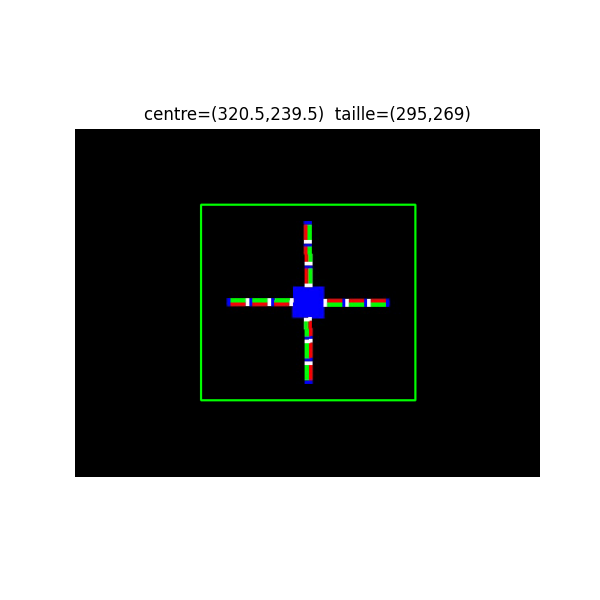

✅ Sauvé dans: initialization/escrime-4-3_init.json


In [9]:
cx, cy = x + w/2.0, y + h/2.0

# Aperçu dans le notebook
vis = frame0_rgb.copy()
cv2.rectangle(vis, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(vis); plt.axis("off")
plt.title(f"centre=({cx:.1f},{cy:.1f})  taille=({w},{h})")
plt.show()

# Sauvegarde pour les étapes 2/3
payload = {
    "video_path": str(VIDEO_PATH),
    "frame_index": 0,
    "roi_xywh": [x, y, w, h],
    "center_xy": [float(cx), float(cy)],
    "size_wh": [w, h],
}
with open(INIT_JSON, "w") as f:
    json.dump(payload, f)

print("✅ Sauvé dans:", INIT_JSON)

In [10]:
def step_1 (video_path,  save_json=True) :
    VIDEO_PATH = Path(video_path)


    cap = cv2.VideoCapture(str(VIDEO_PATH))
    ok, frame0 = cap.read()

    cap.release()
    frame0_rgb = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)

    cv2.namedWindow("Sélectionne l'objet", cv2.WINDOW_NORMAL)
    roi = cv2.selectROI("Sélectionne l'objet", frame0, showCrosshair=True, fromCenter=False)

    # Fermeture robuste (macOS bugfix)
    try:
        cv2.destroyWindow("Sélectionne l'objet")
    except:
        pass
    cv2.waitKey(1)  # force la fermeture effective de la fenêtre

    x, y, w, h = map(int, roi)

    cx, cy = x + w/2.0, y + h/2.0
    # --- Dictionnaire de résultats ---
    result = {
        "video_path": str(video_path),
        "frame_index": 0,
        "roi_xywh": [x, y, w, h],
        "center_xy": [float(cx), float(cy)],
        "size_wh": [w, h],
    }

    # --- Sauvegarde JSON (optionnelle) ---
    if save_json:
        init_dir = Path("initialization")
        init_dir.mkdir(exist_ok=True)
        save_path = init_dir / f"{video_path.stem}_init.json"
        with open(save_path, "w") as f:
            json.dump(result, f, indent=2)
        print(f"Infos sauvegardées dans {save_path}")

    print(f"Centre: ({cx:.1f}, {cy:.1f})  Taille: ({w}, {h})")
    return result

In [11]:
def step_2(video_path, init_json_path, bins=(16,16,16), color_space="HSV", save_npy=True):

    video_path = Path(video_path)
    init_json_path = Path(init_json_path)

    # --- 1. Lire la première frame ---
    cap = cv2.VideoCapture(str(video_path))
    ok, frame0 = cap.read()
    cap.release()
    assert ok, f"Impossible de lire la première frame de {video_path}"

    frame0_rgb = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)

    # --- 2. Charger la ROI de la step 1 ---
    with open(init_json_path, "r") as f:
        init_data = json.load(f)
    x, y, w, h = map(int, init_data["roi_xywh"])

    # --- 3. Extraire la zone à suivre ---
    roi = frame0_rgb[y:y+h, x:x+w]

    # --- 4. Convertir l’espace couleur ---
    if color_space.upper() == "HSV":
        roi_cs = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
        ranges = [0,180, 0,256, 0,256]
    else:
        roi_cs = roi
        ranges = [0,256, 0,256, 0,256]

    # --- 5. Calculer l’histogramme 3D ---
    hist = cv2.calcHist([roi_cs], [0,1,2], None, bins, ranges)

    # --- 6. Normaliser (somme = 1) ---
    hist = cv2.normalize(hist, None, alpha=1.0, norm_type=cv2.NORM_L1)

    # --- 7. Aplatir en vecteur ---
    h_ref = hist.flatten().astype(np.float32)

    # --- 8. Sauvegarde optionnelle ---
    if save_npy:
        out_path = Path("initialization") / f"{video_path.stem}_href.npy"
        np.save(out_path, h_ref)
        print(f"Sauvegardé dans : {out_path}")

    return h_ref

In [12]:
def step_3_init_particles(
    img_shape,
    center_xy,
    size_wh,
    N=300,
    sigma_ratio=(0.25,0.25),
    seed=None):

    if seed is not None:
        np.random.seed(seed)

    # dimensions image
    if len(img_shape) == 3:
        H, W, _ = img_shape
    else:
        H, W = img_shape

    cx, cy = map(float, center_xy)
    w,  h  = map(float, size_wh)

    # écarts-types (pixels) proportionnels à la taille de la boîte
    sx = sigma_ratio[0] * w
    sy = sigma_ratio[1] * h

    # échantillonnage gaussien autour du centre
    dx = np.random.randn(N) * sx
    dy = np.random.randn(N) * sy
    xs = cx + dx
    ys = cy + dy

    # clamp: centres valides pour que la ROI soit entièrement dans l'image
    x_min, x_max = w/2.0, W - w/2.0
    y_min, y_max = h/2.0, H - h/2.0
    xs = np.clip(xs, x_min, x_max)
    ys = np.clip(ys, y_min, y_max)

    particles = np.stack([xs, ys], axis=1).astype(np.float32)
    weights   = np.full((N,), 1.0/ N, dtype=np.float32)  # poids égaux et déjà normalisés

    return particles, weights

In [13]:
def pf_predict(
    particles,
    img_shape,
    size_wh,
    sigma_xy=None,
    ratio_w_h=(0.25,0.25),
    rng=None
):

    if rng is None:
        rng = np.random.default_rng()

    # dimensions image
    H, W = img_shape[:2]
    w, h = map(float, size_wh)

    # écarts-types
    if sigma_xy is None:
        sx = ratio_w_h[0] * w
        sy = ratio_w_h[1] * h
    else:
        sx, sy = sigma_xy

    # bruit gaussien
    dx = rng.normal(0.0, sx, size=len(particles))
    dy = rng.normal(0.0, sy, size=len(particles))

    # mise à jour
    x_new = particles[:, 0] + dx
    y_new = particles[:, 1] + dy

    # clamp pour que la ROI (w,h) reste dans l'image
    x_min, x_max = w/2.0, W - w/2.0
    y_min, y_max = h/2.0, H - h/2.0
    x_new = np.clip(x_new, x_min, x_max)
    y_new = np.clip(y_new, y_min, y_max)

    return np.stack([x_new, y_new], axis=1).astype(np.float32)

In [14]:
def bhattacharyya_dist(h1, h2):
    # h1, h2 normalisés (somme=1)
    # dist = sqrt(1 - sum_i sqrt(h1_i * h2_i))
    bc = np.sum(np.sqrt(h1 * h2))
    bc = np.clip(bc, 0.0, 1.0)           # sécurité numérique
    return float(np.sqrt(max(0.0, 1.0 - bc)))

In [15]:
def hist_on_centered_roi(frame_rgb, center_xy, size_wh, bins=(16,16,16), color_space="HSV"):
    cx, cy = center_xy
    w, h = map(int, size_wh)
    H, W = frame_rgb.shape[:2]

    # borne pour que la ROI w×h reste dans l'image
    x1 = int(round(cx - w/2)); x2 = x1 + w
    y1 = int(round(cy - h/2)); y2 = y1 + h
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(W, x2); y2 = min(H, y2)

    roi = frame_rgb[y1:y2, x1:x2]
    if roi.size == 0 or (x2-x1) < 2 or (y2-y1) < 2:
        # ROI trop petite -> renvoyer histo quasi nul (évite crash)
        return np.full((bins[0]*bins[1]*bins[2],), 1e-12, dtype=np.float32)

    if color_space.upper() == "HSV":
        roi_cs = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
        ranges = [0,180, 0,256, 0,256]
    else:
        roi_cs = roi
        ranges = [0,256, 0,256, 0,256]

    hist = cv2.calcHist([roi_cs], [0,1,2], None, bins, ranges)
    hist = cv2.normalize(hist, None, alpha=1.0, norm_type=cv2.NORM_L1)  # somme=1
    return hist.flatten().astype(np.float32)

In [16]:
def pf_correct(
    frame_rgb,
    particles,
    weights,
    h_ref,
    size_wh,
    bins=(16,16,16),
    color_space="HSV",
    lam=10.0
):
    N = len(particles)
    new_weights = np.empty_like(weights, dtype=np.float64)

    for i in range(N):
        h_i = hist_on_centered_roi(frame_rgb, particles[i], size_wh, bins=bins, color_space=color_space)

        if h_i.sum() <= 0:
            lik = 1e-12
        else:
            d = bhattacharyya_dist(h_ref, h_i)
            lik = np.exp(-lam * (d**2))
        new_weights[i] = weights[i] * lik

    # normalisation des poids (éviter somme nulle)
    s = new_weights.sum()
    if s <= 0:
        new_weights[:] = 1.0 / N
    else:
        new_weights /= s

    return new_weights